# Household Power Consumption

Interesting one...
Would be good for a decent-sized test.  Several millions rows and lots of possible features.

## Example Raw Data

`Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000
16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000`

## Data Format

1. Date - DD/MM/YYYY
2. Time - HH:MM:SS
3. Household Global Minute-Averaged Active Power - KW/min
4. Household Global Minute-Averaged Reactive Power - KW/min
5. Minute-Averaged Voltage - V/min
6. Household Global Minute-Averaged Current Intensity - A/min
7. Energy Sub-Metering No. 1 - W/hr (kitchen - dishwasher, oven, microwave (hot plates not electric))
8. Energy Sub-Metering No. 2 - W/hr (laundry room - washing-machine, tumble-drier, refrigerator, light)
9. Energy Sub-Metering No. 3 - W/hr (water-heater, air-conditioner)

** Some missing values, ~1.25%

## Observations

* #3 * 1000 / 60 => Household Global Active Power - W/hr
* (#3 * 1000 / 60) - #7 - #8 - #9 => Rest of Home - W/hr

## Other Stuff...

* Active Power
* Reactive Power
* True Power = Active Power + Reactive Power?
* Holidays, weekends..!
* Aggregations..!  E.g. provide last week's data at min intervals, then one month at hour intervals, then last year, etc.

* Daily patterns (people in morning, no one in day, people in evening, etc.)
* Weekly patterns (weekdays vs weekends)
* Seasonal patterns (spring, summer, etc.)
* Overlays (holidays - Thanksgiving, Christmas, etc.)
* Overlays (family vacations)

## Models...

* Regression on next minute's data...  This is sorta cute but how useful could it possibly be..?
* Regression on next hour..?  Maybe, this feels right-ish...  Maybe, every 3 hours because that would cover a period in the life of the inhabitant (e.g. getting up and getting ready, working, etc.)

## Get the Data, Mr Potata...

In [1]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import gcp.bigquery as bq

In [2]:
%%sql --module extraction

DEFINE QUERY raw_data
SELECT ts, global_active_power, global_reactive_power, voltage, intensity, sub_meter_1, sub_meter_2, sub_meter_3
FROM [bingo-ml-1:electricity.household_usage_ts]
ORDER BY ts ASC

In [3]:
raw_data_results = bq.Query(extraction.raw_data).results()
raw_data_results

ts,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.36,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.52,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.52,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.7,0.52,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.51,233.99,15.8,0.0,1.0,17.0
2006-12-16 17:33:00,3.662,0.51,233.86,15.8,0.0,2.0,16.0


In [4]:
raw_data = raw_data_results.to_dataframe(start_row=0, max_rows=100000)

In [5]:
raw_data[:10]

,ts,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0,2,16


In [6]:
training_data = raw_data.set_index('ts')
training_data = training_data.resample('T', fill_method='ffill')
training_data[:10]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
ts,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17


In [7]:
training_data.describe()

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
count,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000
mean,1.646368,0.128445,240.819521,6.960163,1.315425,1.909837,7.518409
std,1.343910,0.117188,3.463118,5.668531,6.689033,7.610505,8.668014
min,0.194000,0.000000,223.490000,0.800000,0.000000,0.000000,0.000000
25%,0.396000,0.000000,238.530000,1.800000,0.000000,0.000000,0.000000
50%,1.416000,0.116000,241.050000,5.800000,0.000000,0.000000,0.000000
75%,2.418000,0.198000,243.280000,10.000000,0.000000,1.000000,17.000000
max,9.410000,0.874000,251.700000,41.800000,77.000000,78.000000,20.000000


In [8]:
'''_ = training_data.plot(figsize=(20, 15))'''

'_ = training_data.plot(figsize=(20, 15))'

In [9]:
'''_ = training_data.global_active_power.plot(figsize=(20, 15))'''

'_ = training_data.global_active_power.plot(figsize=(20, 15))'

In [10]:
'''_ = training_data.global_reactive_power.plot(figsize=(20, 15))'''

'_ = training_data.global_reactive_power.plot(figsize=(20, 15))'

In [11]:
'''_ = training_data.voltage.plot(figsize=(20, 15))'''

'_ = training_data.voltage.plot(figsize=(20, 15))'

In [12]:
'''_ = training_data.intensity.plot(figsize=(20, 15))'''

'_ = training_data.intensity.plot(figsize=(20, 15))'

In [13]:
'''_ = training_data.sub_meter_1.plot(figsize=(20, 15))'''

'_ = training_data.sub_meter_1.plot(figsize=(20, 15))'

In [14]:
'''_ = training_data.sub_meter_2.plot(figsize=(20, 15))'''

'_ = training_data.sub_meter_2.plot(figsize=(20, 15))'

In [15]:
'''_ = training_data.sub_meter_3.plot(figsize=(20, 15))'''

'_ = training_data.sub_meter_3.plot(figsize=(20, 15))'

In [16]:
'''_ = training_data.sub_meter_1.plot(figsize=(20, 15), label='sub_meter_1')
_ = training_data.sub_meter_2.plot(figsize=(20, 15), label='sub_meter_2')
_ = training_data.sub_meter_3.plot(figsize=(20, 15), label='sub_meter_3')
_ = plt.legend(loc='upper right')'''

"_ = training_data.sub_meter_1.plot(figsize=(20, 15), label='sub_meter_1')\n_ = training_data.sub_meter_2.plot(figsize=(20, 15), label='sub_meter_2')\n_ = training_data.sub_meter_3.plot(figsize=(20, 15), label='sub_meter_3')\n_ = plt.legend(loc='upper right')"

In [17]:
'''training_data.corr()'''

'training_data.corr()'

In [18]:
'''_ = scatter_matrix(training_data, figsize=(20, 20), diagonal='kde')'''

"_ = scatter_matrix(training_data, figsize=(20, 20), diagonal='kde')"

In [19]:
training_data_processed = training_data.copy()

In [20]:
training_data_processed['global_active_power_w_hr'] = (training_data_processed.global_active_power * 1000) / 60
training_data_processed['global_reactive_power_w_hr'] = (training_data_processed.global_reactive_power * 1000) / 60
training_data_processed[:10]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,global_active_power_w_hr,global_reactive_power_w_hr
ts,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17,70.266667,6.966667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16,89.333333,7.266667
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17,89.566667,8.300000
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17,89.800000,8.366667
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17,61.100000,8.800000
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17,58.666667,8.700000
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17,61.700000,8.666667
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17,61.666667,8.666667
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17,61.133333,8.500000


In [21]:
training_data_processed['rest_of_home_pseudo_sub_meter'] = \
  training_data_processed.global_active_power_w_hr \
  - training_data_processed.sub_meter_1 \
  - training_data_processed.sub_meter_2 \
  - training_data_processed.sub_meter_3
training_data_processed[:10]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,global_active_power_w_hr,global_reactive_power_w_hr,rest_of_home_pseudo_sub_meter
ts,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17,70.266667,6.966667,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16,89.333333,7.266667,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17,89.566667,8.300000,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17,89.800000,8.366667,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17,61.100000,8.800000,43.100000
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17,58.666667,8.700000,39.666667
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17,61.700000,8.666667,43.700000
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17,61.666667,8.666667,43.666667
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17,61.133333,8.500000,43.133333


In [22]:
training_data_scaled = training_data_processed.copy()

from sklearn.preprocessing import MinMaxScaler

training_data_scaled = training_data_scaled.apply(lambda x: MinMaxScaler().fit_transform(x))
  
training_data_scaled = training_data_scaled.drop('global_active_power_w_hr', 1)
training_data_scaled = training_data_scaled.drop('global_reactive_power_w_hr', 1)
  
training_data_scaled.describe()

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,rest_of_home_pseudo_sub_meter
count,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000
mean,0.157592,0.146963,0.614304,0.150248,0.017083,0.024485,0.375920,0.126514
std,0.145824,0.134082,0.122762,0.138257,0.086871,0.097571,0.433401,0.122835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021918,0.000000,0.533144,0.024390,0.000000,0.000000,0.000000,0.033387
50%,0.132595,0.132723,0.622474,0.121951,0.000000,0.000000,0.000000,0.065428
75%,0.241319,0.226545,0.701524,0.224390,0.000000,0.012821,0.850000,0.202208
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
'''plot = training_data_scaled.plot(figsize=(20, 15))
plot.set_ylim([0.0,1.2])
_ = plot.legend(loc='upper right')'''

"plot = training_data_scaled.plot(figsize=(20, 15))\nplot.set_ylim([0.0,1.2])\n_ = plot.legend(loc='upper right')"

In [24]:
'''fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(training_data_scaled.global_active_power, label='global_active_power')
_ = autocorrelation_plot(training_data_scaled.global_reactive_power, label='global_reactive_power')
_ = autocorrelation_plot(training_data_scaled.voltage, label='voltage')
_ = autocorrelation_plot(training_data_scaled.intensity, label='intensity')
_ = autocorrelation_plot(training_data_scaled.sub_meter_1, label='sub_meter_1')
_ = autocorrelation_plot(training_data_scaled.sub_meter_2, label='sub_meter_2')
_ = autocorrelation_plot(training_data_scaled.sub_meter_3, label='sub_meter_3')
_ = autocorrelation_plot(training_data_scaled.rest_of_home_pseudo_sub_meter, label='rest_of_home_pseudo_sub_meter')

_ = plt.legend(loc='upper right')'''

"fig = plt.figure()\nfig.set_figwidth(20)\nfig.set_figheight(15)\n\n_ = autocorrelation_plot(training_data_scaled.global_active_power, label='global_active_power')\n_ = autocorrelation_plot(training_data_scaled.global_reactive_power, label='global_reactive_power')\n_ = autocorrelation_plot(training_data_scaled.voltage, label='voltage')\n_ = autocorrelation_plot(training_data_scaled.intensity, label='intensity')\n_ = autocorrelation_plot(training_data_scaled.sub_meter_1, label='sub_meter_1')\n_ = autocorrelation_plot(training_data_scaled.sub_meter_2, label='sub_meter_2')\n_ = autocorrelation_plot(training_data_scaled.sub_meter_3, label='sub_meter_3')\n_ = autocorrelation_plot(training_data_scaled.rest_of_home_pseudo_sub_meter, label='rest_of_home_pseudo_sub_meter')\n\n_ = plt.legend(loc='upper right')"

In [25]:
training_data_scaled[:2]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,rest_of_home_pseudo_sub_meter
ts,,,,,,,,
2006-12-16 17:24:00,0.436415,0.478261,0.402340,0.429268,0,0.012821,0.85,0.413840
2006-12-16 17:25:00,0.560547,0.498856,0.359447,0.541463,0,0.012821,0.80,0.575929


In [26]:
training_data_scaled[-2:]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,rest_of_home_pseudo_sub_meter
ts,,,,,,,,
2007-02-24 04:10:00,0.022569,0.286041,0.631691,0.029268,0,0.025641,0,0.029618
2007-02-24 04:11:00,0.022352,0.283753,0.620702,0.024390,0,0.012821,0,0.037426


'import matplotlib\nplot.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())'

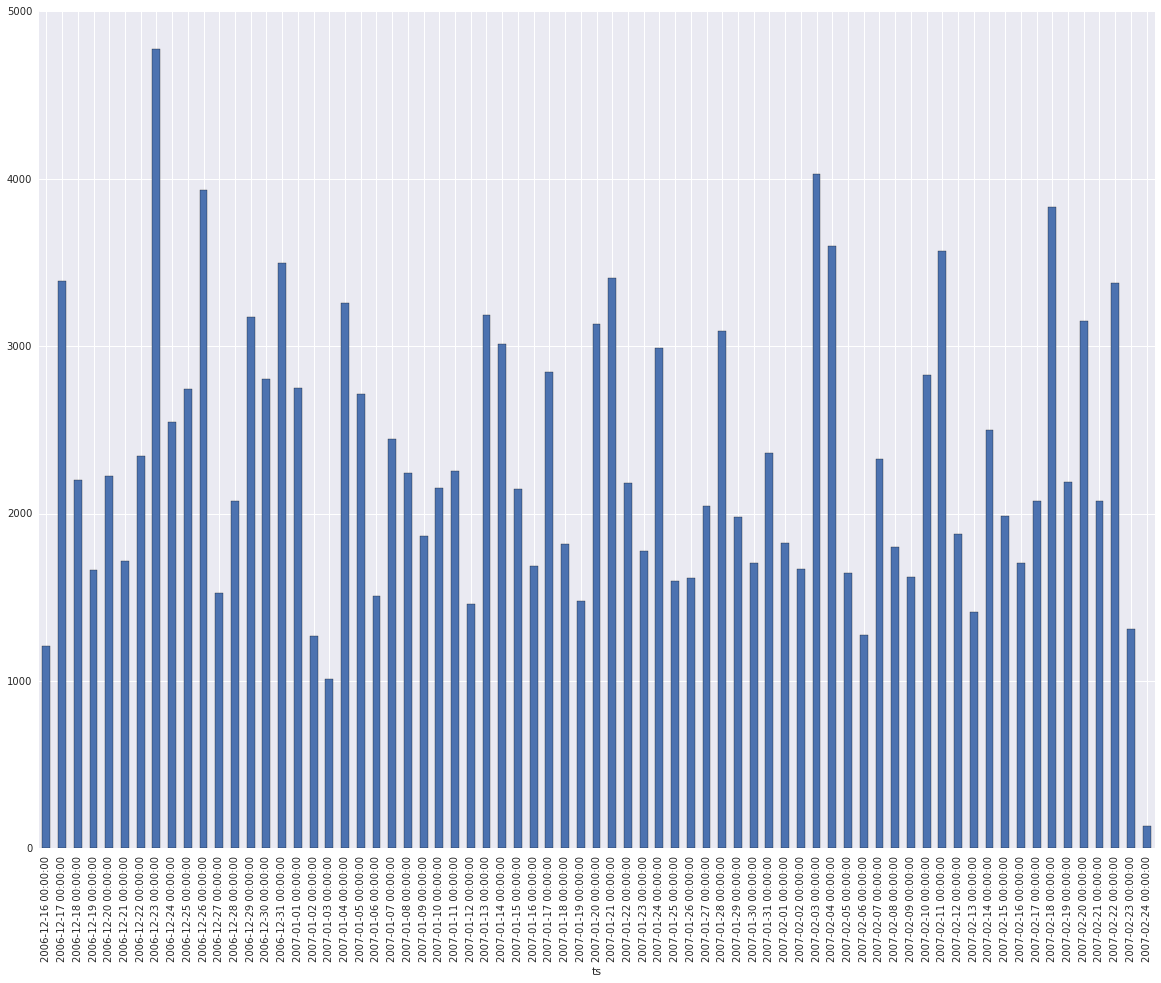

In [27]:
# Let's try some aggregations...

'''training_data_aggregated_5_min = training_data_processed.copy()
training_data_aggregated_5_min = training_data_aggregated.resample('5T', how='sum')

training_data_aggregated_15_min = training_data_processed.copy()
training_data_aggregated_15_min = training_data_aggregated.resample('15T', how='sum')

training_data_aggregated_1_hr = training_data_processed.copy()
training_data_aggregated_1_hr = training_data_aggregated_1_hr.resample('H', how='sum')'''

training_data_aggregated_1_day = training_data_processed.copy()
training_data_aggregated_1_day = training_data_aggregated_1_day.resample('D', how='sum')

plot = training_data_aggregated_1_day.global_active_power.plot(kind='bar')
plot.figure.set_figwidth(20)
_ = plot.figure.set_figheight(15)

'''import matplotlib
plot.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())'''

In [28]:
import tensorflow as tf

In [29]:
window = 30

training_data_tf_rows = []
for i in range(window+1, len(training_data_scaled)):
  ts = training_data_scaled.index[i]
  value = training_data_scaled.global_active_power[i]
  global_active_power_feature = training_data_scaled.global_active_power[i-1:i-1-window:-1]
  global_reactive_power_feature = training_data_scaled.global_reactive_power[i-1:i-1-window:-1]
  voltage_feature = training_data_scaled.voltage[i-1:i-1-window:-1]
  intensity_feature = training_data_scaled.intensity[i-1:i-1-window:-1]
  sub_meter_1_feature = training_data_scaled.sub_meter_1[i-1:i-1-window:-1]
  sub_meter_2_feature = training_data_scaled.sub_meter_2[i-1:i-1-window:-1]
  sub_meter_3_feature = training_data_scaled.sub_meter_3[i-1:i-1-window:-1]
  rest_of_home_pseudo_sub_meter_feature = training_data_scaled.rest_of_home_pseudo_sub_meter[i-1:i-1-window:-1]
    
  training_data_tf_row = np.concatenate([[ts], [value],
                                      global_active_power_feature.values,
                                      global_reactive_power_feature.values,
                                      voltage_feature.values,
                                      intensity_feature.values,
                                      sub_meter_1_feature.values,
                                      sub_meter_2_feature.values,
                                      sub_meter_3_feature.values,
                                      rest_of_home_pseudo_sub_meter_feature.values])
  training_data_tf_row_dict = dict(enumerate(training_data_tf_row))
  training_data_tf_rows.append(training_data_tf_row_dict)
  #training_data_tf_row_df = pd.DataFrame([training_data_tf_row])
  #training_data_tf = pd.concat([training_data_tf, training_data_tf_row_df])
  
  if (i%10000 == 0):
    print i
  
training_data_tf = pd.DataFrame(training_data_tf_rows)
training_data_tf = training_data_tf.set_index(0)
training_data_tf[:10]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


,1,2,3,4,5,6,7,8,9,10,...,232,233,234,235,236,237,238,239,240,241
0,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:55:00,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,0.540365,0.741319,...,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659,0.575929
2006-12-16 17:56:00,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,0.540365,...,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659
2006-12-16 17:57:00,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,...,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621
2006-12-16 17:58:00,0.419271,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,...,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795
2006-12-16 17:59:00,0.247179,0.419271,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,...,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062
2006-12-16 18:00:00,0.281684,0.247179,0.419271,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,...,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642
2006-12-16 18:01:00,0.263672,0.281684,0.247179,0.419271,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,...,0.294561,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373
2006-12-16 18:02:00,0.279731,0.263672,0.281684,0.247179,0.419271,0.468533,0.450087,0.386719,0.274089,0.323785,...,0.316101,0.294561,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065
2006-12-16 18:03:00,0.384766,0.279731,0.263672,0.281684,0.247179,0.419271,0.468533,0.450087,0.386719,0.274089,...,0.285945,0.316101,0.294561,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257


In [30]:
training_predictors_tf = training_data_tf[training_data_tf.columns[1:]]
training_classes_tf = training_data_tf[training_data_tf.columns[0]]

In [31]:
training_predictors_tf[:5]

,2,3,4,5,6,7,8,9,10,11,...,232,233,234,235,236,237,238,239,240,241
0,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:55:00,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,0.540365,0.741319,0.815104,...,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659,0.575929
2006-12-16 17:56:00,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,0.540365,0.741319,...,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659
2006-12-16 17:57:00,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,0.540365,...,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621
2006-12-16 17:58:00,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,0.464410,...,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795
2006-12-16 17:59:00,0.419271,0.468533,0.450087,0.386719,0.274089,0.323785,0.332465,0.329210,0.330078,0.331380,...,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062


In [32]:
training_classes_tf[:5]

0
2006-12-16 17:55:00    0.386719
2006-12-16 17:56:00    0.450087
2006-12-16 17:57:00    0.468533
2006-12-16 17:58:00    0.419271
2006-12-16 17:59:00    0.247179
Name: 1, dtype: float64

In [33]:
!pip install git+git://github.com/google/skflow.git

Downloading/unpacking git+git://github.com/google/skflow.git
  Cloning git://github.com/google/skflow.git to /tmp/pip-0wZXNE-build
  Running setup.py (path:/tmp/pip-0wZXNE-build/setup.py) egg_info for package from git+git://github.com/google/skflow.git
    
Cleaning up...


In [34]:
import skflow
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

y, X = training_classes_tf.values, training_predictors_tf.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test

(array([[ 0.01497396,  0.01497396,  0.01540799, ...,  0.03392569,
          0.02907916,  0.02207862],
        [ 0.14756944,  0.14800347,  0.14800347, ...,  0.03473344,
          0.02557889,  0.03365644],
        [ 0.02387153,  0.02170139,  0.02387153, ...,  0.04631125,
          0.0455035 ,  0.04711901],
        ..., 
        [ 0.3578559 ,  0.34678819,  0.34657118, ...,  0.23721055,
          0.22455574,  0.23317178],
        [ 0.03125   ,  0.03168403,  0.02560764, ...,  0.02180937,
          0.02207862,  0.02207862],
        [ 0.11697049,  0.11631944,  0.11545139, ...,  0.02800215,
          0.03796446,  0.03069467]]),
 array([ 0.01497396,  0.14735243,  0.02170139, ...,  0.35503472,
         0.03103299,  0.11740451]))

In [35]:
regressor = skflow.TensorFlowDNNRegressor(
  hidden_units=[250, 250],
  steps=50000, 
  learning_rate=0.001, 
  batch_size=1)
regressor.fit(X_train, y_train)
score = mean_squared_error(regressor.predict(X_test), y_test)
print('MSE: {0:f}'.format(score))

Step #1, avg. loss: 0.06411
Step #5001, avg. loss: 0.01146
Step #10001, avg. loss: 0.00588
Step #15001, avg. loss: 0.00490
Step #20001, avg. loss: 0.00443
Step #25001, avg. loss: 0.00390
Step #30001, avg. loss: 0.00350
Step #35001, avg. loss: 0.00295
Step #40001, avg. loss: 0.00322
Step #45001, avg. loss: 0.00295
MSE: 0.002594


In [36]:
tmpd = pd.DataFrame(y_test)
tmpd['xyz'] = regressor.predict(X_test)
print tmpd[:10].dtypes

'''xyz = regressor.predict(X_test)
print len(xyz)

print len(y_test)'''

0      float64
xyz    float32
dtype: object


'xyz = regressor.predict(X_test)\nprint len(xyz)\n\nprint len(y_test)'

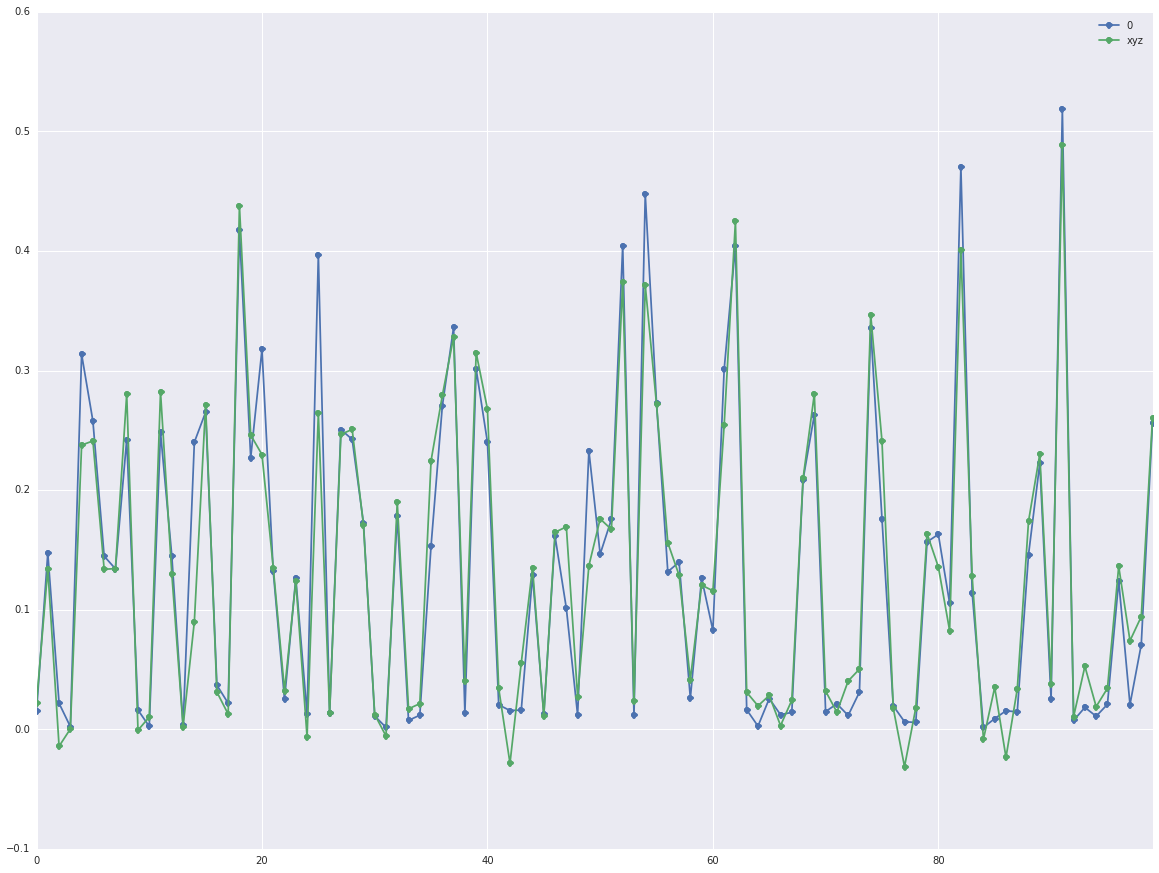

In [37]:
#_ = tmpd[150:200].plot(kind='bar', figsize=(20, 15))
_ = tmpd[:100].plot(style='-o', figsize=(20, 15))